### LoadCachedFragilityCurveMultiple


In [ ]:
from toolbox_continu_inzicht.base.data_adapter import Config, DataAdapter
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

path = Path.cwd() / "data_sets" / "6.1.fragility_curve_database"

config = Config(config_path=path / "test_fragility_curve_database.yaml")
config.lees_config()
data_adapter = DataAdapter(config=config)

<details>
<summary>Yaml: configuratie</summary>

```yaml
GlobalVariables:
    rootdir: "data_sets/6.1.fragility_curve_database"
    moments: [-24,0,24,48]
    LoadCachedFragilityCurve:
        default_measure_id: 0

DataAdapter:

	fragility_curves:
        type: ci_postgresql_fragility_curve_multi_section_multi_failure
        database: "continuinzicht"
        schema: "continuinzicht_demo_realtime"        

    measures_effect:
        type: ci_postgresql_measures_to_effect
        database: "continuinzicht"
        schema: "continuinzicht_demo_realtime"            

    section_measure:
        type: ci_postgresql_section_id_to_measure_id
        database: "continuinzicht"
        schema: "continuinzicht_demo_realtime"  

    save_fragility_curve:
        type: ci_postgresql_fragilitycurves_table
        database: "continuinzicht"
        schema: "continuinzicht_demo_realtime"  
        table: "fragilitycurves"
```
</details>

In [ ]:
# Bij de Multiple werkt het net zo: als je alleen één maatregel getal geeft wordt dat voor alle faalmechanismes en dijkvakken gebruikt.
# Voor verschillende maatregels per faalmechanisme en dijkvak kan een mapping bestand worden meegegeven.

from toolbox_continu_inzicht.fragility_curves import LoadCachedFragilityCurveMultiple

load_cached_fragility_curve = LoadCachedFragilityCurveMultiple(
    data_adapter=data_adapter
)
load_cached_fragility_curve.run(
    input=[
        "fragility_curves",
        "measures_effect",
        "section_measure",
    ],
    # measure_id=3,
    output="save_fragility_curve",
)

### Toon verschil zonder en met gekozen maatregel in figuur

In [ ]:
# type: ignore

# Haal alle unieke faalmechanismes op
failure_mechanism_ids = load_cached_fragility_curve.df_in[
    "failuremechanism_id"
].unique()

# bepaal in en uit dataframe om verschillen te tonen
df_in = load_cached_fragility_curve.df_in
df_out = load_cached_fragility_curve.df_out

# maak plot object aan, aantal plots afhankelijk van aantal
# faalmechanismes en aantal dijkvakken
fig, ax = plt.subplots(
    len(failure_mechanism_ids),
    df_in["section_id"].unique().size,
    figsize=(10, 18),
    constrained_layout=True,
)

# Bij 1D zorgen dat er geen lege rij van plots ontstaat
if len(failure_mechanism_ids) == 1 or df_in["section_id"].unique().size == 1:
    ax = np.atleast_2d(ax)  # altijd 2D


def custom_format(y, pos):
    return f"{y:.2f}" if 0 <= y < 1 or y < 0 else f"{y:.0f}"


# loop over alle faalmechanismes en dijkvakken
for row, fm_id in enumerate(sorted(failure_mechanism_ids)):
    for column, section_id in enumerate(sorted(df_in["section_id"].unique())):
        try:
            df_in_section = df_in[df_in["section_id"] == section_id]
            df_out_section = df_out[df_out["section_id"] == section_id]

            df_in_section[df_in_section["failuremechanism_id"] == fm_id].set_index(
                "hydraulicload"
            )["failure_probability"].mul(100).clip(lower=0.01, upper=100).plot(
                ax=ax[row, column]
            )

            df_out_section[df_out_section["failuremechanism_id"] == fm_id].set_index(
                "hydraulicload"
            )["failure_probability"].mul(100).clip(lower=0.01, upper=100).plot(
                ax=ax[row, column], ls="--"
            )

            measure_id = df_out_section["measure_id"].unique()[0]

            ax[row, column].set_title(
                f"Dijkvak: {section_id},Faalmechanisme: {fm_id}, maatregel: {measure_id}",
                fontsize=8,
            )

            ax[row, column].set_yscale("log", base=10)
            ax[row, column].set_ylim(0.008, 120)
            ax[row, column].yaxis.set_major_formatter(FuncFormatter(custom_format))

            ax[row, column].set_ylabel("Conditionele faalkans (%)")
            ax[row, column].set_xlabel("Waterhoogte (m+NAP)")
            ax[row, column].legend(["Initieel", "Na maatregel"], loc="best", fontsize=8)

        except Exception as e:
            print(e)

plt.show()

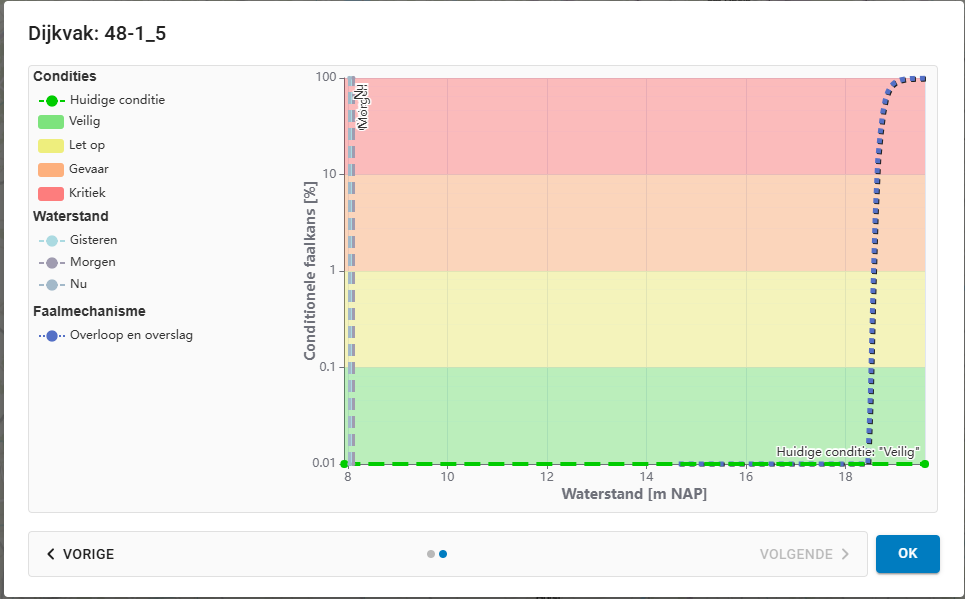